# 1. Importing Necessary Libraries

In [1874]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
import numpyro
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests

In [1875]:
!pip install --upgrade pip
!pip install lightweight_mmm

/Users/shivataherzadeh/anaconda3/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [1876]:
!pip install --upgrade git+https://github.com/google/lightweight_mmm.git

  Cloning https://github.com/google/lightweight_mmm.git to /private/var/folders/q9/22k3yk91617_zml083z7sjz00000gn/T/pip-req-build-5vorn5cd
  Running command git clone --filter=blob:none --quiet https://github.com/google/lightweight_mmm.git /private/var/folders/q9/22k3yk91617_zml083z7sjz00000gn/T/pip-req-build-5vorn5cd
  Resolved https://github.com/google/lightweight_mmm.git to commit 8ac08a189df55f0e17845a05e3f6dbeb3b13fe20
  Preparing metadata (setup.py) ... done


# 2. Loading the Data

In [1877]:
spendings_data=pd.read_csv('Spendings_data.csv')
Radio_data=pd.read_csv('Radio_data.csv')

# 3. EDA and Pre-processing

In [1878]:
spendings_data.head()

Date    Sales  Twitter_spendings  Facebook_spendings  \
0  2015-01-05  2399540         667.162727         22910.80792   
1  2015-01-12  1221910        4349.983960         24086.28992   
2  2015-01-19  2056410        3737.740358         26050.60188   
3  2015-01-26   554520        3976.313510         21302.44032   
4  2015-02-02  2338295        2103.030348         13599.52372   

   Instagram_spendings  TV_spendings  Banner_spendings  
0           587.463467   48090.80000         20.740274  
1           920.978604   24538.20000          5.033326  
2          2599.224645   41228.20000        256.838470  
3          7916.203989   11190.40000        245.551915  
4           546.829951   45676.25453         79.996797

In [1879]:
Radio_data.head()

Year  Month    Sales  Radio_spendings
0  2015      1  6232380      8530.118669
1  2015      2  8704650     16165.598960
2  2015      3  6909730     12205.855299
3  2015      4  7033085      8783.132546
4  2015      5  6623780     11210.308042

In [1880]:
spendings_data.shape

(261, 7)

In [1881]:
Radio_data.shape

(60, 4)

## 3.1 Upsampling

In [1882]:
spendings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 261 non-null    object 
 1   Sales                261 non-null    int64  
 2   Twitter_spendings    261 non-null    float64
 3   Facebook_spendings   261 non-null    float64
 4   Instagram_spendings  249 non-null    float64
 5   TV_spendings         261 non-null    float64
 6   Banner_spendings     261 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 14.4+ KB


In [1883]:
# correcting dtype of 'Date' column in spendings_data dataframe
spendings_data['Date']=pd.to_datetime(spendings_data['Date']) 

In [1884]:
Radio_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             60 non-null     int64  
 1   Month            60 non-null     int64  
 2   Sales            60 non-null     int64  
 3   Radio_spendings  60 non-null     float64
dtypes: float64(1), int64(3)
memory usage: 2.0 KB


In [1885]:
# Creating 'date' column in Radio_data that combines year and month columns
Radio_data['date'] = pd.to_datetime(Radio_data['Year'].astype(str) + '-' + 
                                    Radio_data['Month'].astype(str) + '-01')


In [1886]:
Radio_data.head()

Year  Month    Sales  Radio_spendings       date
0  2015      1  6232380      8530.118669 2015-01-01
1  2015      2  8704650     16165.598960 2015-02-01
2  2015      3  6909730     12205.855299 2015-03-01
3  2015      4  7033085      8783.132546 2015-04-01
4  2015      5  6623780     11210.308042 2015-05-01

In [1887]:
# This step is to match the first dates of each month in Radio_data dataframe to spendings_data dataframe:

# Extracting year and month for grouping
spendings_data['Year'], spendings_data['Month'] = spendings_data['Date'].dt.year, spendings_data['Date'].dt.month
Radio_data['Year'], Radio_data['Month'] = Radio_data['date'].dt.year, Radio_data['date'].dt.month

# Finding the minimum date for each month in spendings_data
min_dates = spendings_data.groupby(['Year', 'Month'])['Date'].min().reset_index()

# Renaming columns for a clear merge
min_dates.rename(columns={'Date': 'Min_Date'}, inplace=True)

# Merging to align the dates in Radio_data to the start day found in spendings_data
Radio_data_updated = Radio_data.merge(min_dates, on=['Year', 'Month'], how='left')

# Updating the 'date' column in Radio_spendings to match the start day from spendings_data
Radio_data_updated['date'] = Radio_data_updated['Min_Date']
Radio_data_updated.drop(['Min_Date'], axis=1, inplace=True)

In [1888]:
Radio_data_updated.head()

Year  Month    Sales  Radio_spendings       date
0  2015      1  6232380      8530.118669 2015-01-05
1  2015      2  8704650     16165.598960 2015-02-02
2  2015      3  6909730     12205.855299 2015-03-02
3  2015      4  7033085      8783.132546 2015-04-06
4  2015      5  6623780     11210.308042 2015-05-04

In [1889]:
# Setting 'date' column as index
Radio_data_updated.set_index('date', inplace=True)

In [1890]:
# adding new date to the end of dataset so that later, upsampling and interpolation happens up until this date
Radio_data_updated.loc[pd.Timestamp('2020-01-07')] = np.nan

In [1891]:
# Upsampling:

# creating empty rows between monthly values
Radio_data_updated=Radio_data_updated.resample('W-MON').mean() 

In [1892]:
Radio_data_updated

Year  Month      Sales  Radio_spendings
date                                                 
2015-01-05  2015.0    1.0  6232380.0      8530.118669
2015-01-12     NaN    NaN        NaN              NaN
2015-01-19     NaN    NaN        NaN              NaN
2015-01-26     NaN    NaN        NaN              NaN
2015-02-02  2015.0    2.0  8704650.0     16165.598960
...            ...    ...        ...              ...
2019-12-16     NaN    NaN        NaN              NaN
2019-12-23     NaN    NaN        NaN              NaN
2019-12-30     NaN    NaN        NaN              NaN
2020-01-06     NaN    NaN        NaN              NaN
2020-01-13     NaN    NaN        NaN              NaN

[263 rows x 4 columns]

In [1893]:
# Removing the row that we created before
Radio_data_updated=Radio_data_updated[:-2] 

In [1894]:
Radio_data_updated.head()

Year  Month      Sales  Radio_spendings
date                                                 
2015-01-05  2015.0    1.0  6232380.0      8530.118669
2015-01-12     NaN    NaN        NaN              NaN
2015-01-19     NaN    NaN        NaN              NaN
2015-01-26     NaN    NaN        NaN              NaN
2015-02-02  2015.0    2.0  8704650.0     16165.598960

In [1895]:
# Filling the nan values in 'Sales' and 'Radio_spendings' columns with monthly values divided by number of weeks:

# Looping over the columns 'Sales' and 'Radio_spendings'
for k in ['Sales', 'Radio_spendings']:
    
    # Looping over the years from 2015 to 2019
    for j in range(2015, 2020):
        
        # Looping over the months from January to December
        for i in range(1, 13):
            
            # Counting the number of NaN values in the current subset
            nan_count = Radio_data_updated[(Radio_data_updated.index.month == i) & (Radio_data_updated.index.year == j)][k].isna().sum()
            
            # Extracting the monthly value for the current subset
            monthly_value = Radio_data_updated[(Radio_data_updated.index.month == i) & (Radio_data_updated.index.year == j)][k].values[0]
            
            # Calculating the weekly value by dividing the monthly value by the number of NaN values plus one
            weekly_value = monthly_value / (nan_count+1)
            
            # Updating the DataFrame with the weekly value for the current subset
            Radio_data_updated.loc[(Radio_data_updated.index.month == i) & (Radio_data_updated.index.year == j), k] = weekly_value

/var/folders/q9/22k3yk91617_zml083z7sjz00000gn/T/ipykernel_21948/3262876779.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Radio_data_updated.loc[(Radio_data_updated.index.month == i) & (Radio_data_updated.index.year == j), k] = weekly_value


## 3.2 Merging Two Datasets

In [1896]:
# Setting 'Date' column as index for spendings_data dataframe to be able to merge the two dataframes on index
spendings_data.set_index('Date', inplace=True)

# Merging the two dataframes
Merged_df=pd.merge(spendings_data, Radio_data_updated, left_index=True, right_index=True)

In [1897]:
# Removing 'Year' and 'Month' columns
Merged_df=Merged_df.drop('Year_x', axis=1)
Merged_df=Merged_df.drop('Year_y', axis=1)
Merged_df=Merged_df.drop('Month_x', axis=1)
Merged_df=Merged_df.drop('Month_y', axis=1)

# Combining 'Sales_x' and 'Sales_y' columns
Merged_df['Sales']=Merged_df['Sales_x']+Merged_df['Sales_y']

# Removing 'Sales_x' and 'Sales_y' columns
Merged_df=Merged_df.drop('Sales_x', axis=1)
Merged_df=Merged_df.drop('Sales_y', axis=1)

## 3.4 Outlier Detection

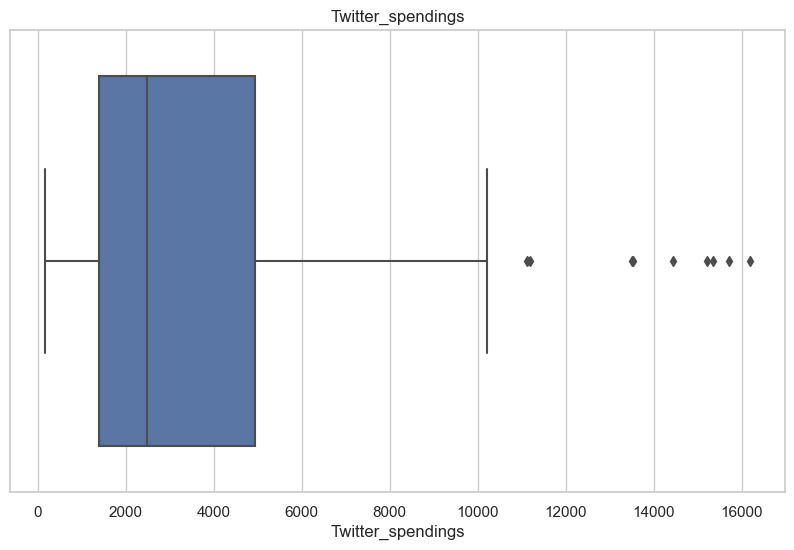

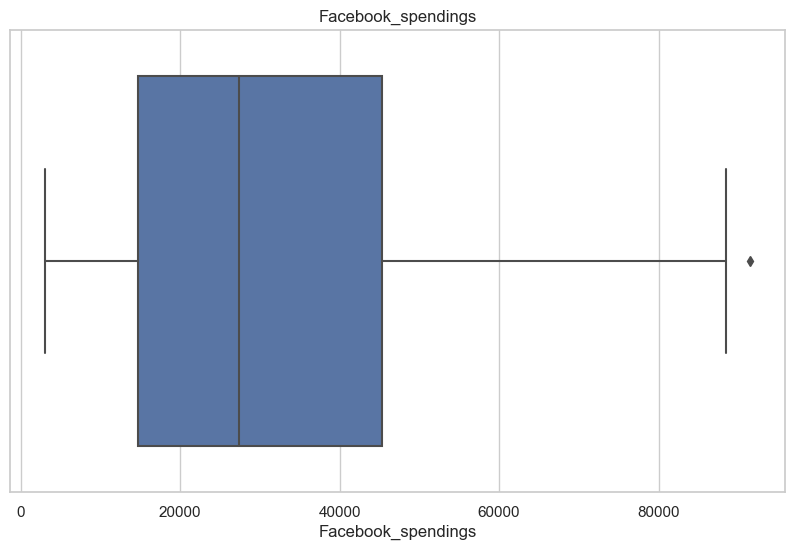

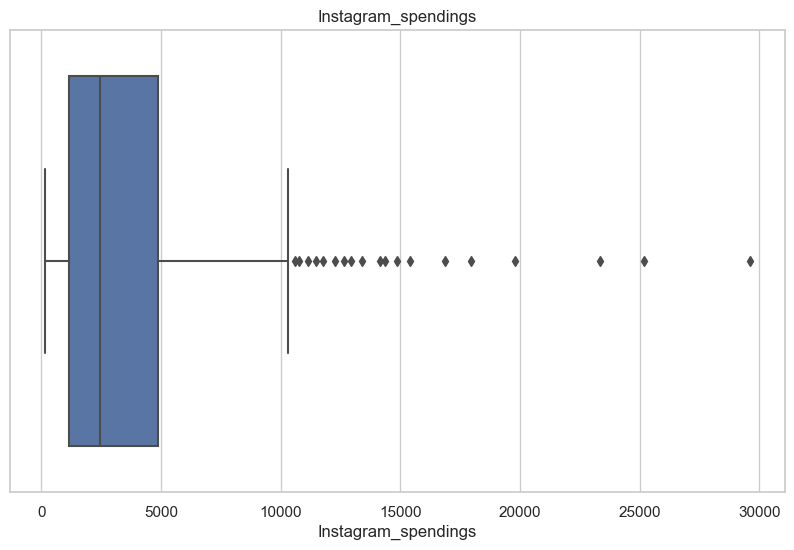

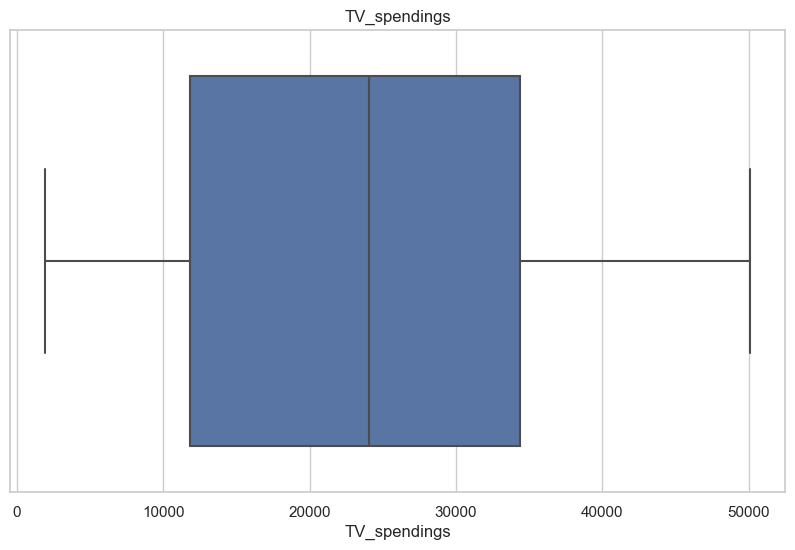

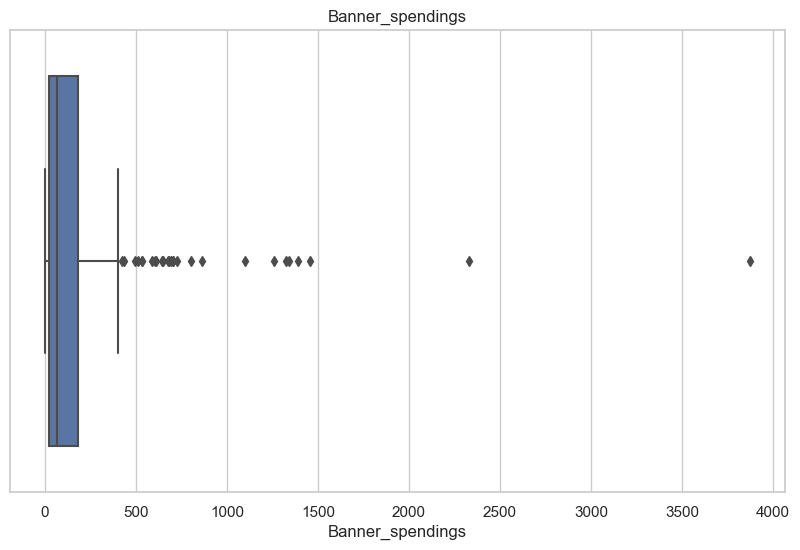

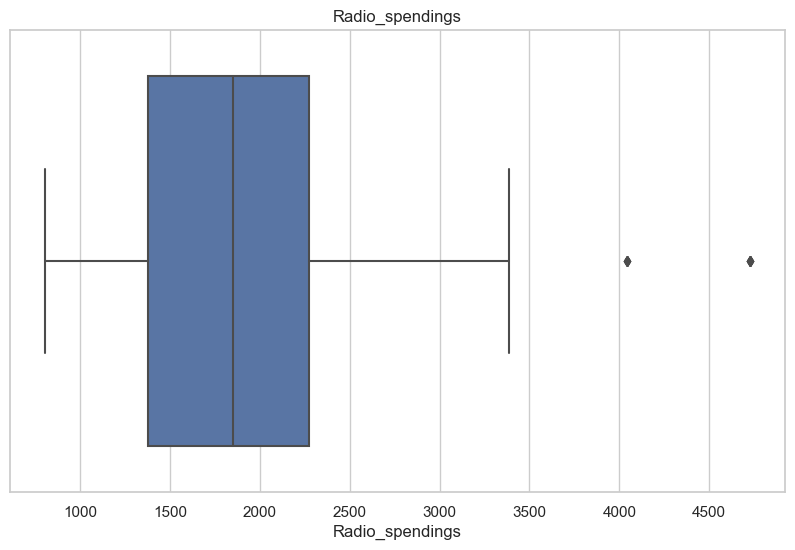

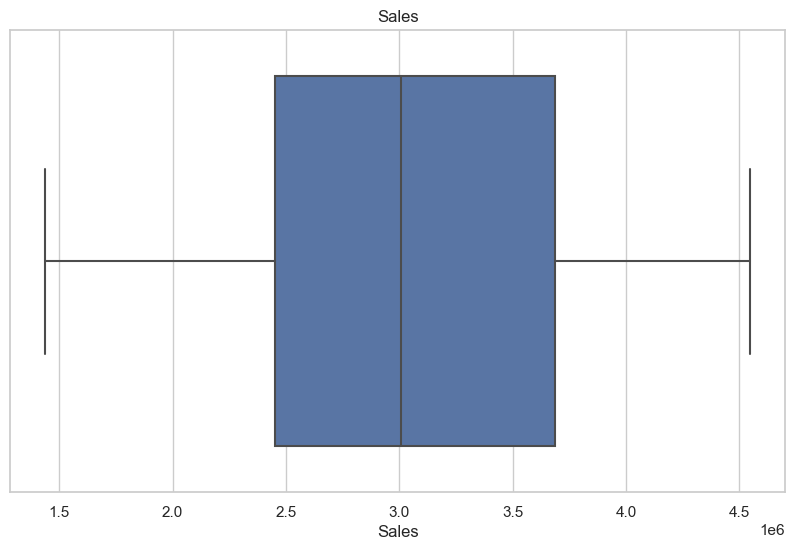

In [1898]:
# Creating box plots 
for column in Merged_df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=Merged_df[column])
    plt.title(column)
    plt.show()

In [1899]:
# Removing outliers from each column using IQR method:

Merged_df_filtered = Merged_df.copy()

for column in Merged_df_filtered.columns:
    # Calculating quartiles for the current column
    percentile25 = Merged_df_filtered[column].quantile(0.25)
    percentile75 = Merged_df_filtered[column].quantile(0.75)
    
    # Calculating the Interquartile Range (IQR) for the current column
    iqr = percentile75 - percentile25
    
    # Finding the upper and lower limits
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
    # Filtering rows based on the IQR limits
    filtered_rows = (Merged_df_filtered[column] >= lower_limit) & (Merged_df_filtered[column] <= upper_limit)
    
    # Updating the DataFrame to include only rows within the IQR limits
    Merged_df_filtered = Merged_df_filtered[filtered_rows]

# Display the shape of the filtered DataFrame
Merged_df_filtered.shape


(199, 7)

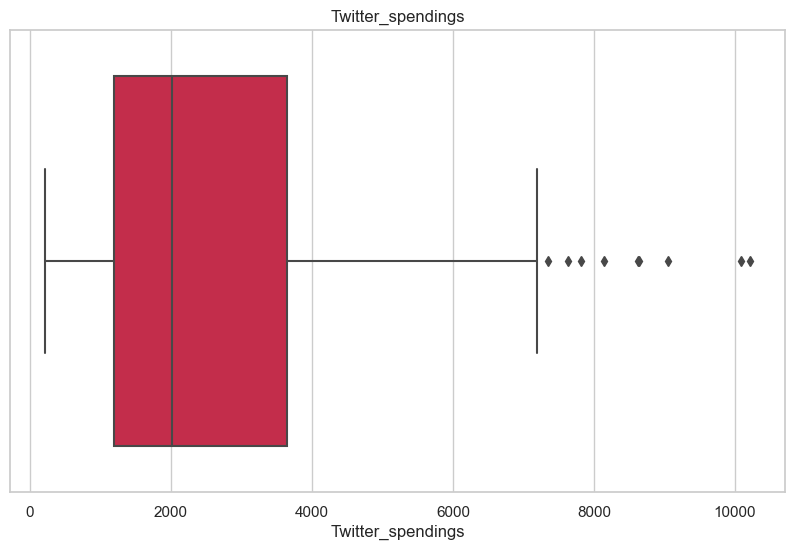

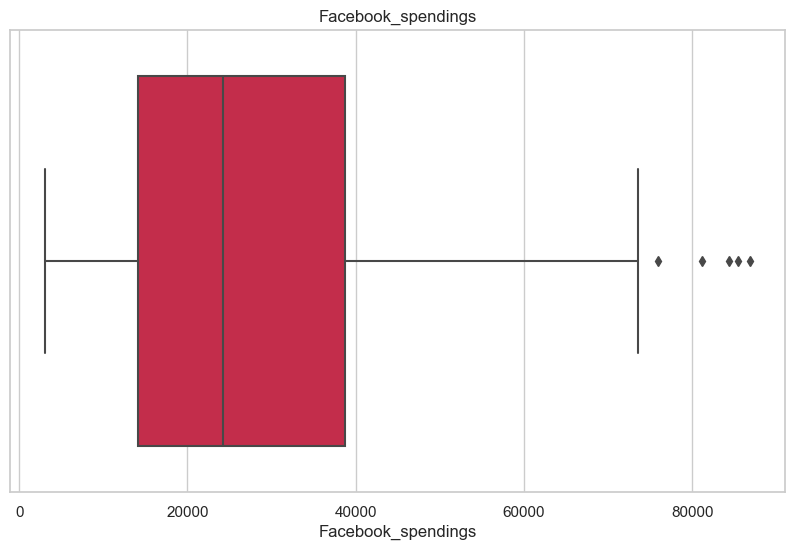

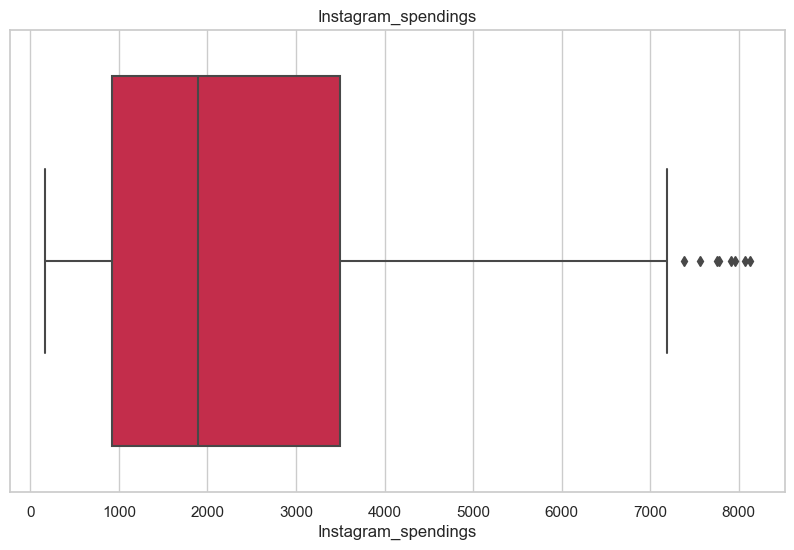

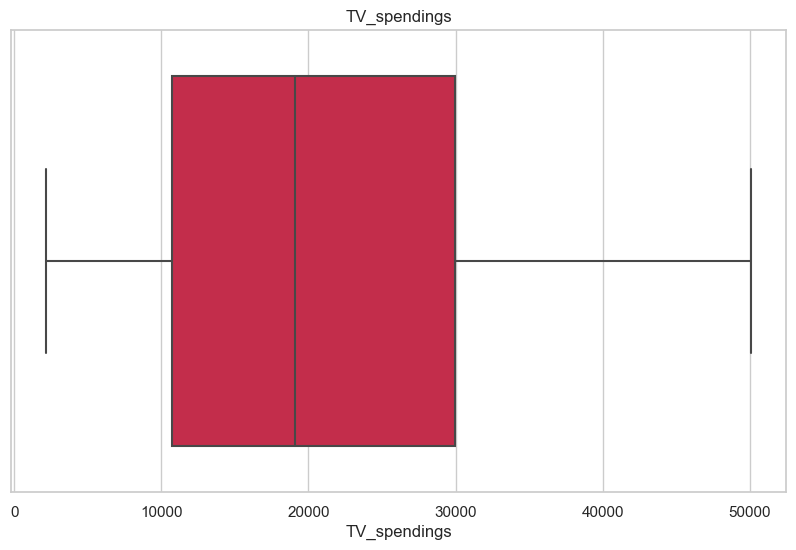

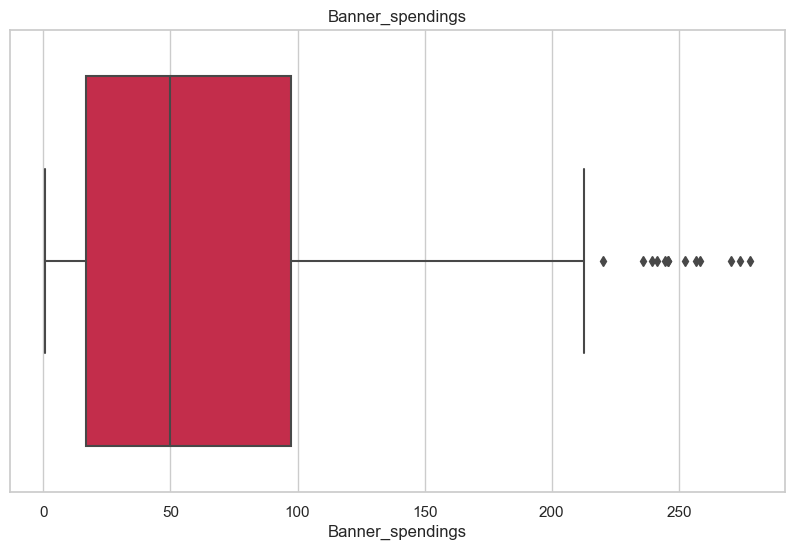

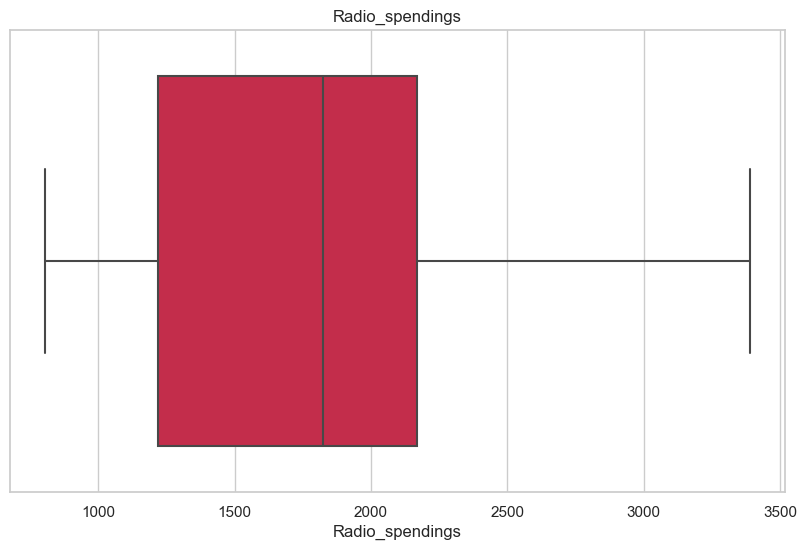

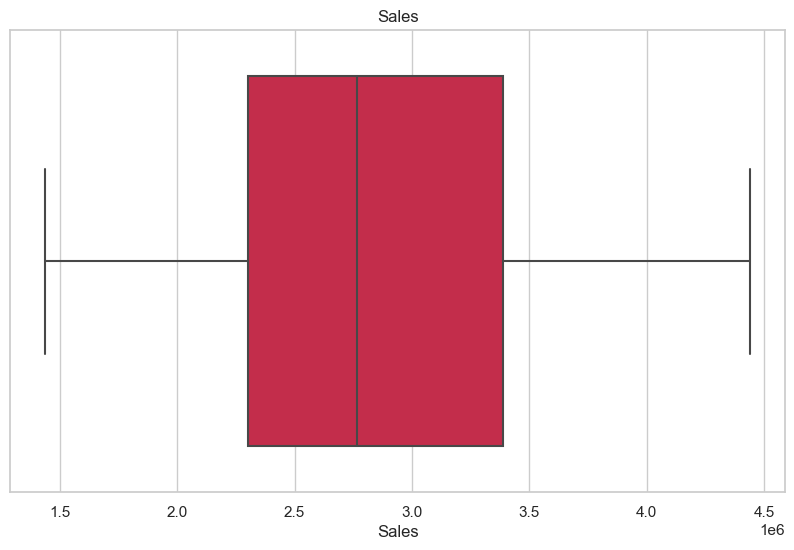

In [1900]:
# creating box plots again, after outlier removal to see the change
for column in Merged_df_filtered.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=Merged_df_filtered[column], color='crimson')
    plt.title(column)
    plt.show()

## 3.3 Dealing with Missing Values

In [1901]:
# Checking if there are missing values
Merged_df.isnull().sum()

Twitter_spendings       0
Facebook_spendings      0
Instagram_spendings    12
TV_spendings            0
Banner_spendings        0
Radio_spendings         0
Sales                   0
dtype: int64

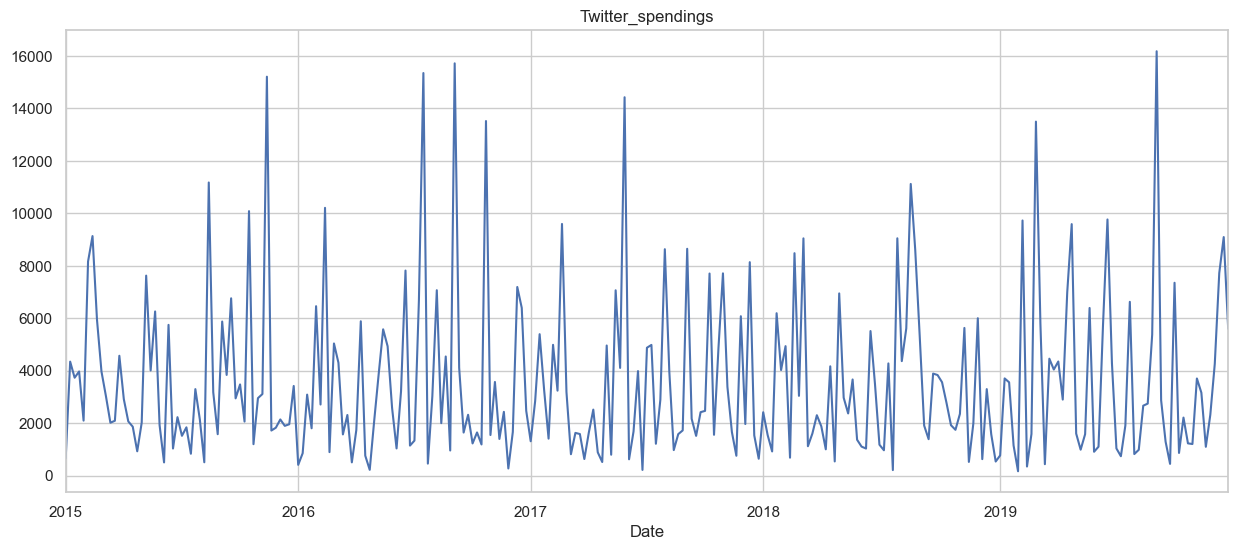

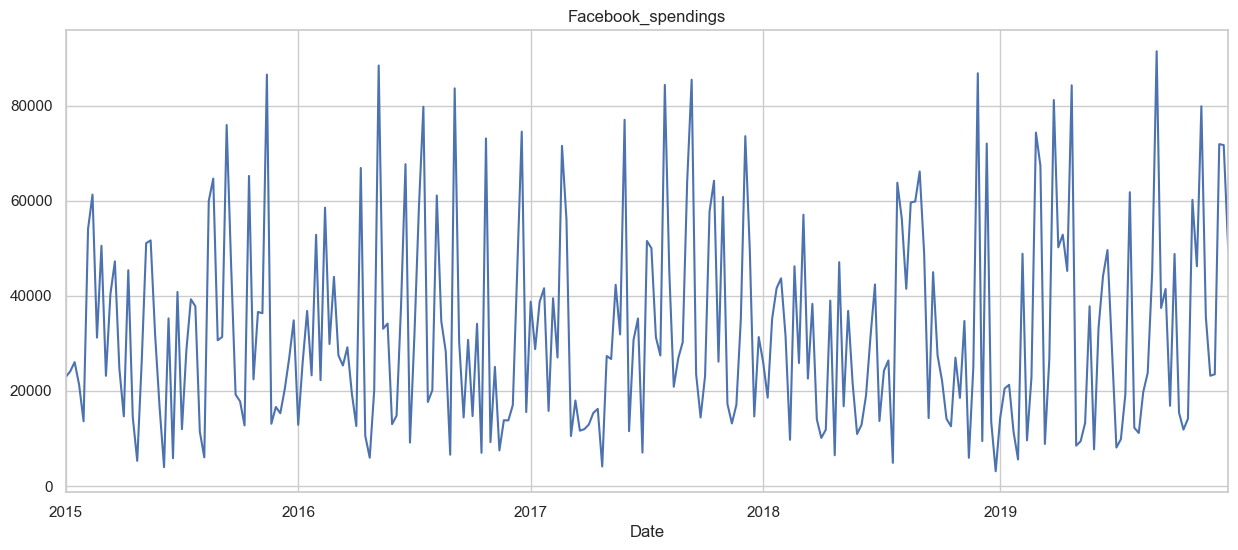

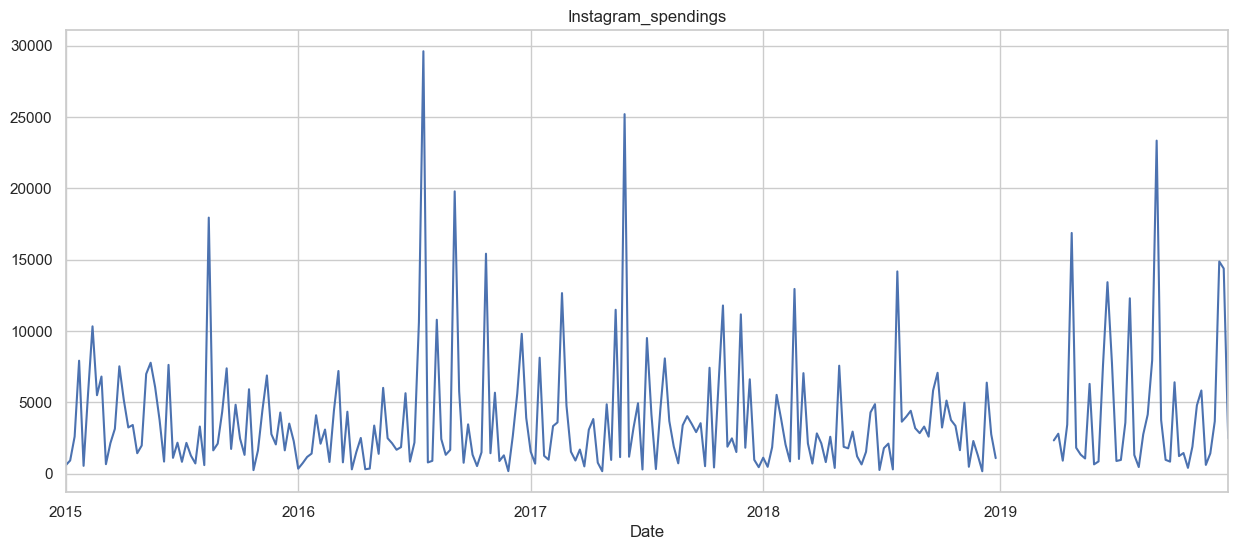

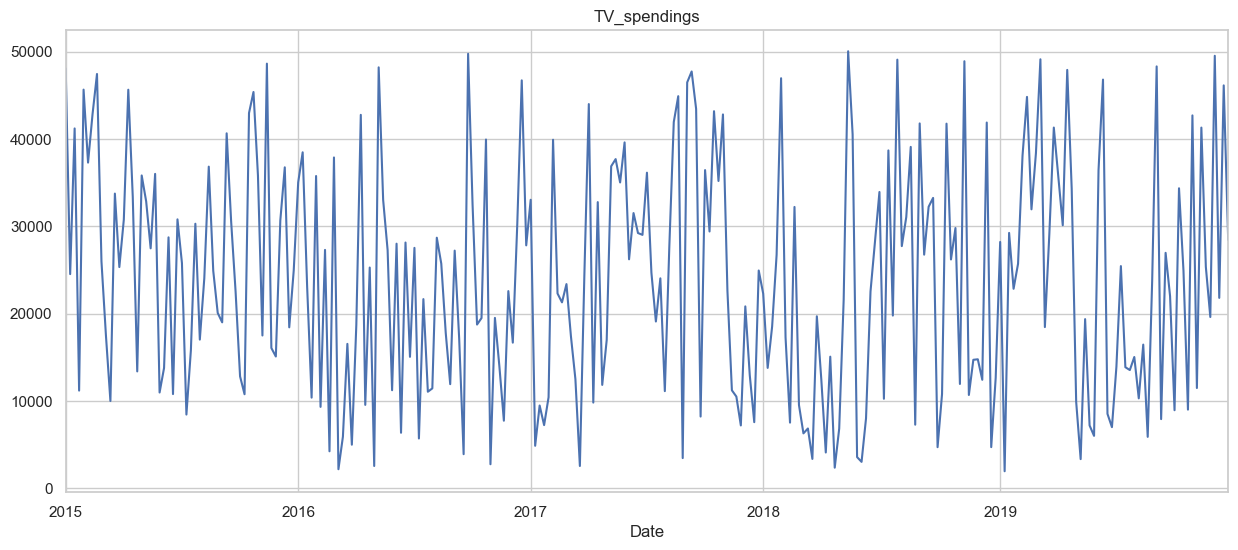

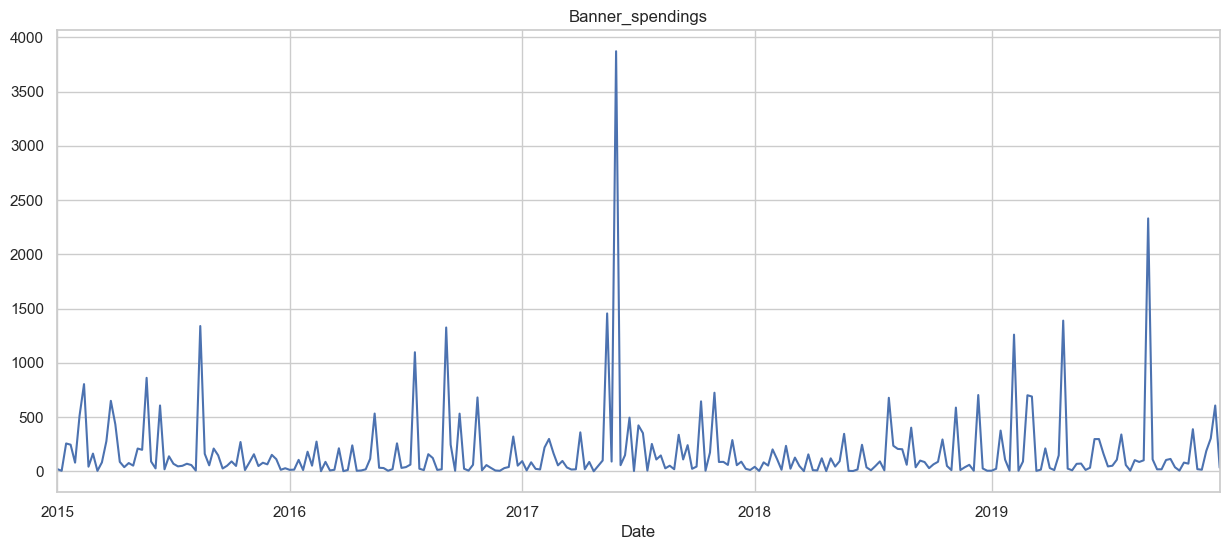

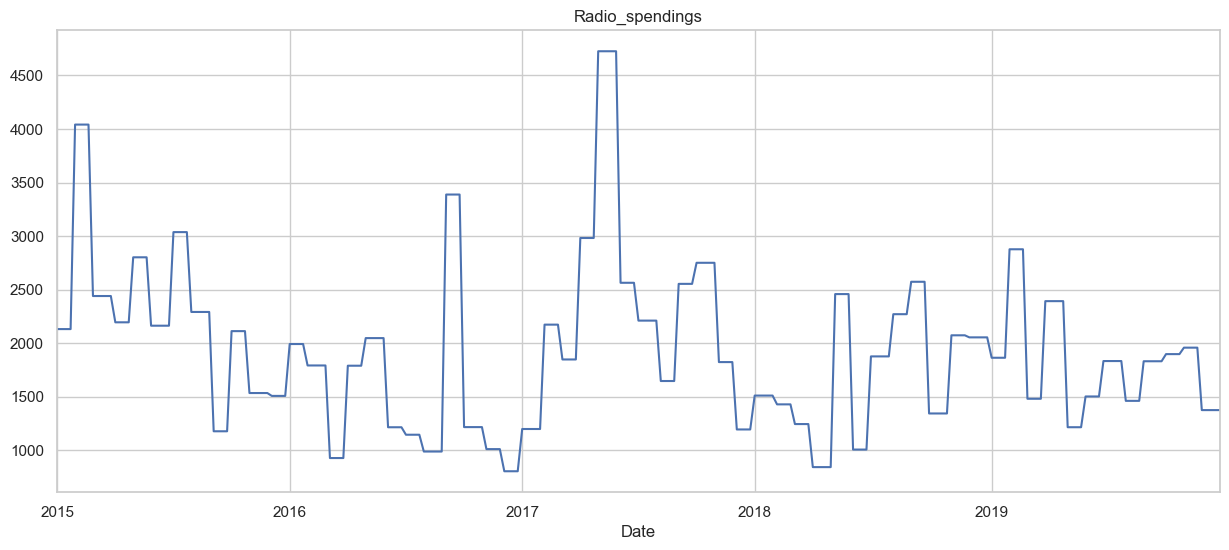

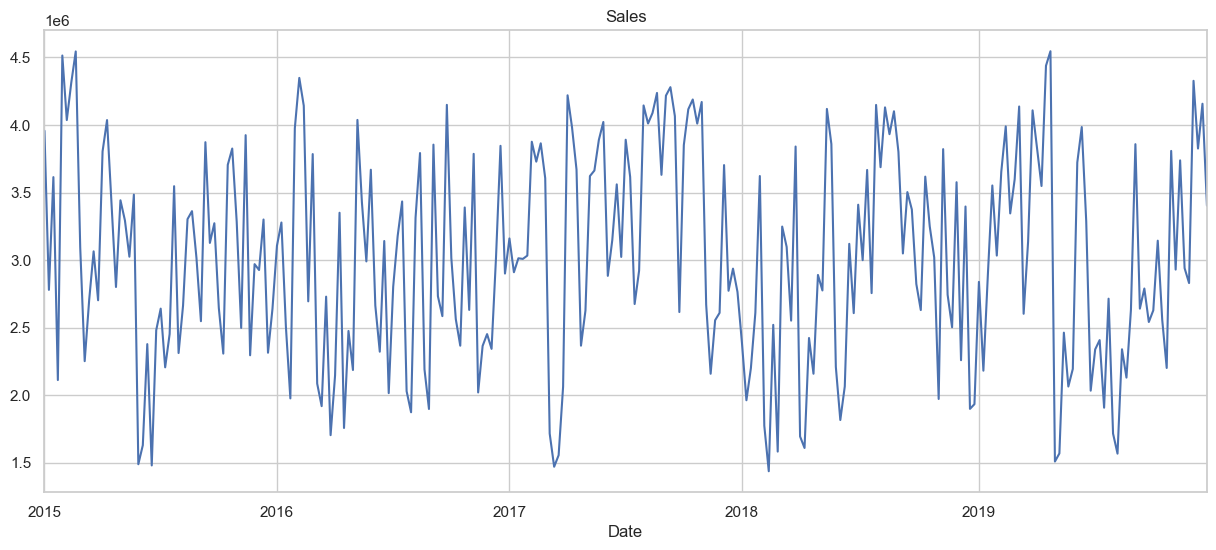

In [1902]:
# Plotting each column over time to decide on interpolation method
for i in Merged_df.columns:
    Merged_df[i].plot(figsize=(15, 6))
    plt.title(i)  
    plt.show()

In [1903]:
# Applying Spline Interpolation to fill in the 'Instagram_spendings' missing values
Merged_df_filtered['Instagram_spendings'] = Merged_df_filtered['Instagram_spendings'].interpolate(method='spline', order=3)

## 3.5 Checking the Distribution of Columns

In [1904]:
# checking the basic statistics
Merged_df_filtered.describe()

Twitter_spendings  Facebook_spendings  Instagram_spendings  \
count         199.000000          199.000000           199.000000   
mean         2689.635253        28243.877236          2518.651911   
std          2051.340877        17867.663881          2008.007812   
min           218.555094         3094.805340           168.039557   
25%          1200.127726        14139.798400           920.793227   
50%          2022.612374        24213.850160          1888.735188   
75%          3642.573702        38751.194910          3502.369328   
max         10210.478892        86814.644880          8125.186575   

       TV_spendings  Banner_spendings  Radio_spendings         Sales  
count    199.000000        199.000000       199.000000  1.990000e+02  
mean   20954.435035         71.015115      1786.407790  2.835806e+06  
std    12389.123221         70.642033       588.676409  7.443367e+05  
min     2180.210480          0.763323       805.623509  1.437625e+06  
25%    10731.471315         16.890084      1217.666257  2.302130e+06  
50%    19106.400000         49.743755      1824.510449  2.764939e+06  
75%    29975.800000         97.327367      2169.117828  3.389129e+06  
max    50073.200000        277.863922      3388.427112  4.438854e+06

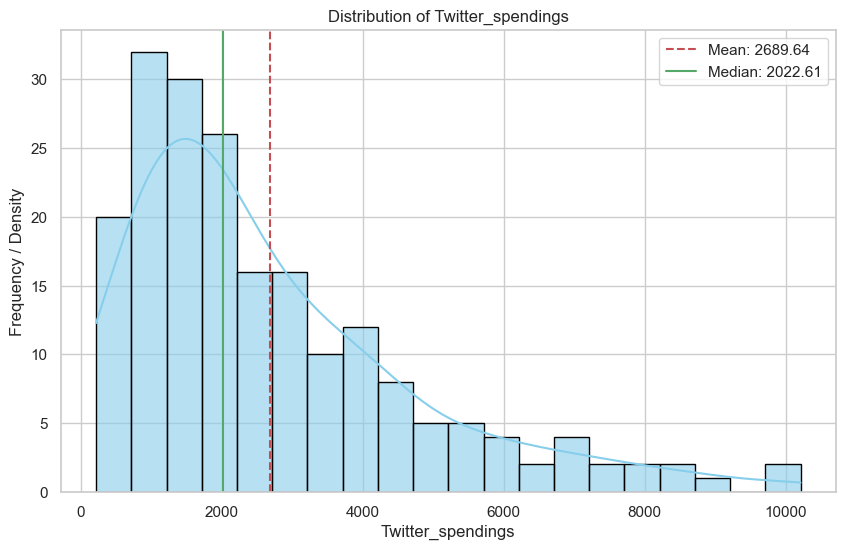

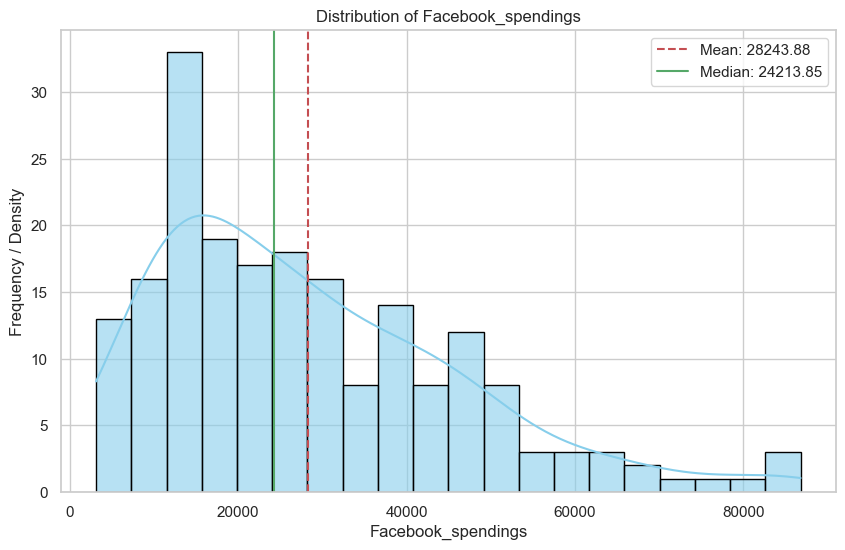

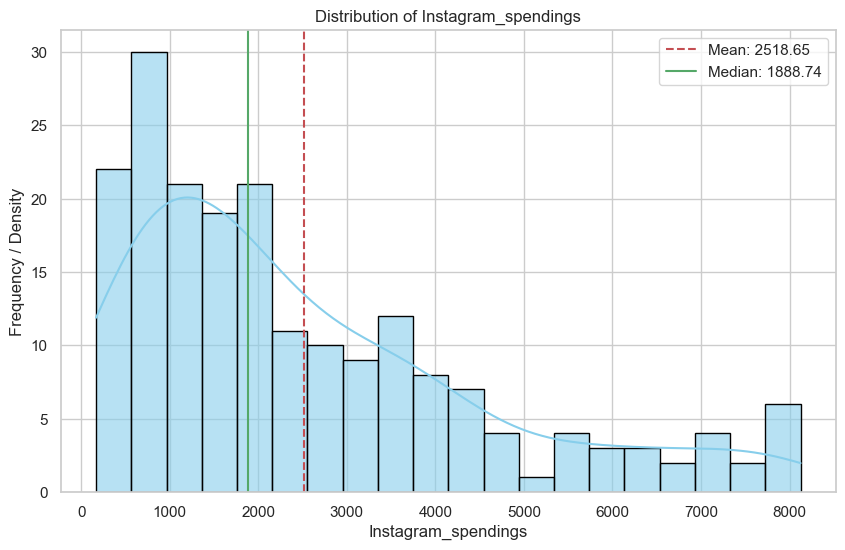

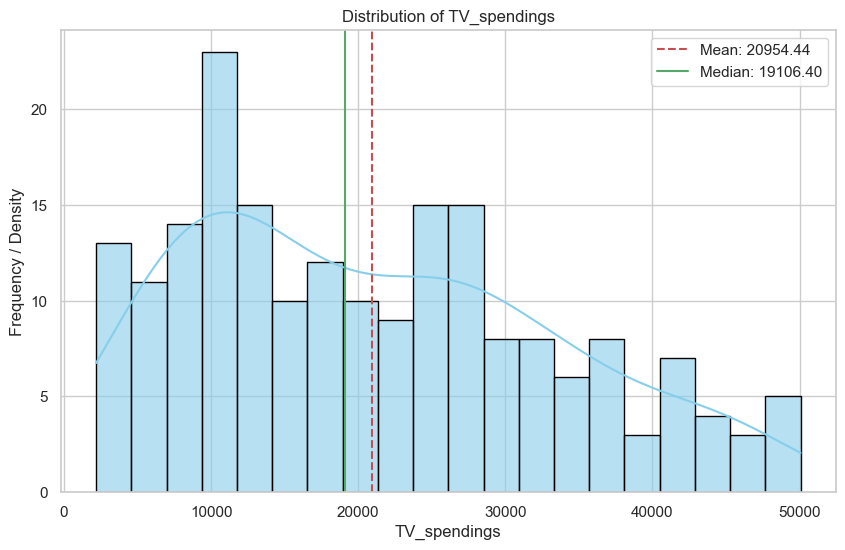

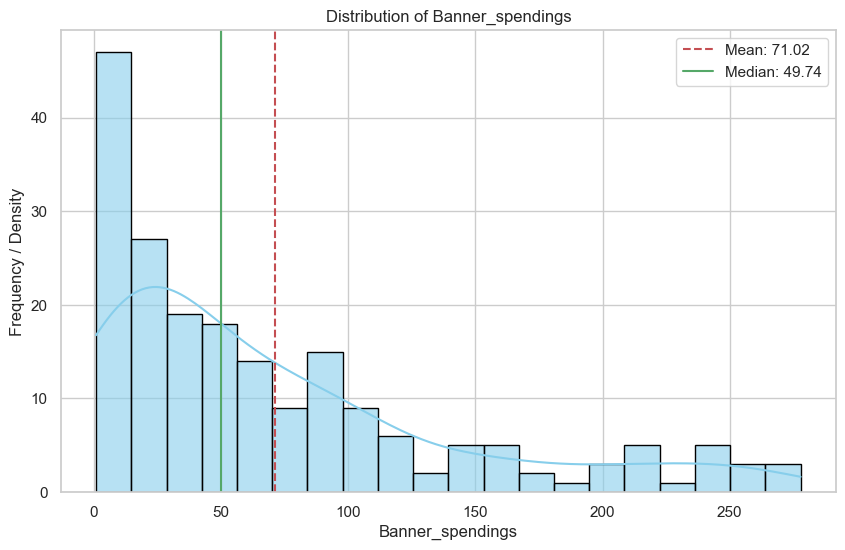

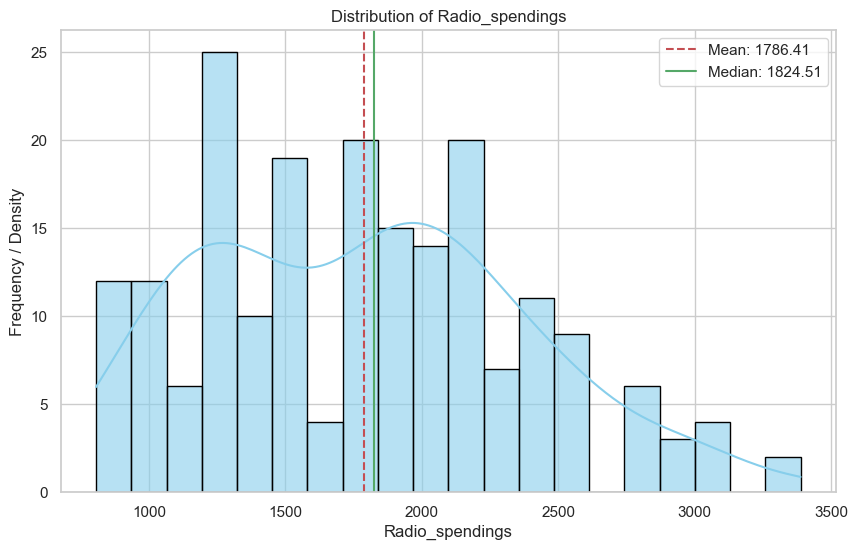

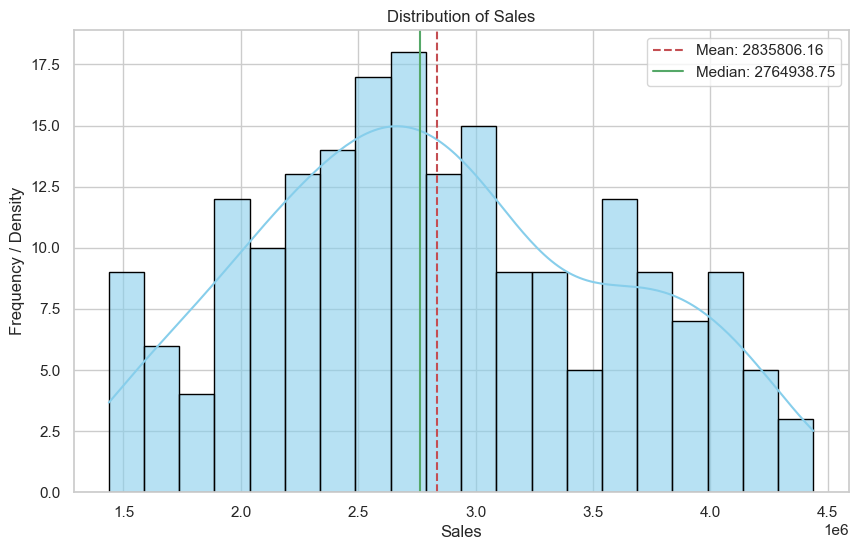

In [1905]:
# checking histogram and density plots for all columns in Merged_df_filtered dataframe:

# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

for column in Merged_df_filtered.columns:
    plt.figure(figsize=(10, 6))
    
    # Combining histogram and KDE in one plot
    sns.histplot(Merged_df_filtered[column], kde=True, bins=20, color="skyblue", alpha=0.6, edgecolor='black')
    
    # Calculating mean and median
    mean_value = Merged_df_filtered[column].mean()
    median_value = Merged_df_filtered[column].median()
    
    # Adding mean and median lines
    plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='g', linestyle='-', label=f'Median: {median_value:.2f}')
    
    # Customizing the plot
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency / Density')
    plt.legend()
    
    plt.show()


## 3.6 Correlation Analysis

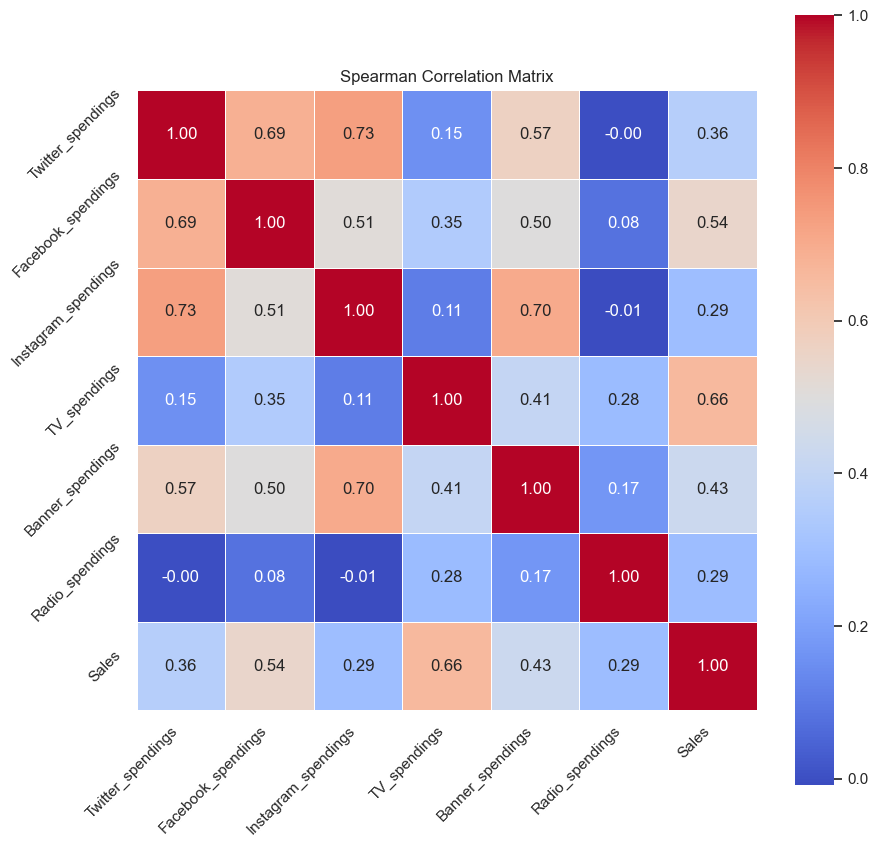

In [1906]:
# Creating a heatmap:

corr2 = Merged_df_filtered.corr(method='spearman')

# Choosing a figure size
plt.figure(figsize=(10, 10)) 

# Plotting the heatmap
ax = sns.heatmap(corr2, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=.5)

# Improving readability
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45)
plt.title("Spearman Correlation Matrix")

plt.show()

## 3.7 Granger Causality Analysis

Granger Causality helps us understand the adstock effect.
But, before applying granger causality test, we must make sure columns are stationary. We use both ADF and KPSS tests to check the stationarity of columns. 

In [1907]:
# ADF test:

for i in Merged_df_filtered.columns:

    result = adfuller(Merged_df_filtered[i])

    # Extracting the p-value from the ADF test result
    p_value = result[1]
    print(i,p_value)

    # Comparing the p-value to a significance level (e.g., 0.05) to make a decision about stationarity
    if p_value < 0.05:
        print(i,"is stationary.")
    else:
        print(i,"is non-stationary.")

Twitter_spendings 1.5224350751357735e-26
Twitter_spendings is stationary.
Facebook_spendings 1.3960943185623186e-24
Facebook_spendings is stationary.
Instagram_spendings 2.6921271897681004e-21
Instagram_spendings is stationary.
TV_spendings 1.823753721285288e-24
TV_spendings is stationary.
Banner_spendings 3.940583480456147e-21
Banner_spendings is stationary.
Radio_spendings 1.3098715955057764e-06
Radio_spendings is stationary.
Sales 3.824175294380138e-17
Sales is stationary.


We can see that based on ADF test, all columns are stationary, meaning that our columns don't have a unit root.
Now, we will apply KPSS test.

In [1908]:
# KPSS test:

for i in Merged_df_filtered.columns:

    result = kpss(Merged_df_filtered[i])

    # Extracting the p-value from the KPSS test result
    p_value = result[1]
    print(i,p_value)

    # Comparing the p-value to a significance level (e.g., 0.05) to make a decision about stationarity
    if p_value < 0.05:
        print(i,"is non-stationary.")
    else:
        print(i,"is stationary.")


Twitter_spendings 0.1
Twitter_spendings is stationary.
Facebook_spendings 0.1
Facebook_spendings is stationary.
Instagram_spendings 0.1
Instagram_spendings is stationary.
TV_spendings 0.1
TV_spendings is stationary.
Banner_spendings 0.043189614464980035
Banner_spendings is non-stationary.
Radio_spendings 0.1
Radio_spendings is stationary.
Sales 0.1
Sales is stationary.


/Users/shivataherzadeh/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/shivataherzadeh/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/shivataherzadeh/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/shivataherzadeh/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the r

We can see that based on KPSS test also, all columns are stationary meaning that our columns don't have a deterministic trend. 
Now we can apply Granger Causality test.

In [1909]:
Merged_df_filtered.columns

Index(['Twitter_spendings', 'Facebook_spendings', 'Instagram_spendings',
       'TV_spendings', 'Banner_spendings', 'Radio_spendings', 'Sales'],
      dtype='object')

In [1910]:
# Granger Causality test:

# Initializing empty lists to store the cause variable names, lag values, and p-values respectively
a = []
c = []
d = []

# Iterating over the first 6 columns of the Merged_df_filtered DataFrame
for i in Merged_df_filtered.columns[0:6]:
    # Performing Granger causality tests between 'Sales' and the current column 'i', for lags up to 20
    x = grangercausalitytests(Merged_df_filtered[['Sales', i]][2:], maxlag=20)
    
    # Iterating through each lag from 1 to 20
    for k in range(1, 21):
        # Appending the current column name to list 'a' as the cause variable
        a.append(i)
        # Appending the current lag value to list 'c'
        c.append(k)
        # Appending the p-value of the ssr_ftest for the current lag to list 'd'
        d.append(x[k][0]['ssr_ftest'][1])

# Creating a DataFrame 'df' with columns for 'cause', 'lag', and 'p_value'
df = pd.DataFrame(columns=['cause', 'lag', 'p_value'])

# Populating the 'cause', 'lag', and 'p_value' columns with the data from lists 'a', 'c', and 'd'
df['cause'] = a
df['lag'] = c
df['p_value'] = d



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3705  , p=0.5435  , df_denom=193, df_num=1
ssr based chi2 test:   chi2=0.3762  , p=0.5396  , df=1
likelihood ratio test: chi2=0.3759  , p=0.5398  , df=1
parameter F test:         F=0.3705  , p=0.5435  , df_denom=193, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1834  , p=0.8326  , df_denom=190, df_num=2
ssr based chi2 test:   chi2=0.3765  , p=0.8284  , df=2
likelihood ratio test: chi2=0.3761  , p=0.8286  , df=2
parameter F test:         F=0.1834  , p=0.8326  , df_denom=190, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3043  , p=0.2744  , df_denom=187, df_num=3
ssr based chi2 test:   chi2=4.0593  , p=0.2551  , df=3
likelihood ratio test: chi2=4.0174  , p=0.2596  , df=3
parameter F test:         F=1.3043  , p=0.2744  , df_denom=187, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5006  , p=0.2038  

In [1911]:
df

cause  lag   p_value
0    Twitter_spendings    1  0.543472
1    Twitter_spendings    2  0.832560
2    Twitter_spendings    3  0.274407
3    Twitter_spendings    4  0.203792
4    Twitter_spendings    5  0.264809
..                 ...  ...       ...
115    Radio_spendings   16  0.348762
116    Radio_spendings   17  0.416233
117    Radio_spendings   18  0.286211
118    Radio_spendings   19  0.255070
119    Radio_spendings   20  0.242783

[120 rows x 3 columns]

In [1912]:
# Saving the file to visualize it in Tableau
df.to_excel('granger_causality_sales1.xlsx', index=False)

## 3.8 Feature Engineering

We create new features to have more features with high correlation with sales and increase the model's accuracy.
(This step was done after the initial model training, to improve the accuracy of the model).

In [1913]:
# Computing ratios or proportions between sales and individual spending variables.
spending_columns = [
    'Twitter_spendings', 'Facebook_spendings', 'Instagram_spendings', 
    'TV_spendings', 'Banner_spendings', 'Radio_spendings'
]

# Calculating the ratios of spendings to sales for each spending category
for column in spending_columns:
    ratio_column_name = f"{column}_to_sales_ratio"
    Merged_df_filtered[ratio_column_name] = Merged_df_filtered[column] / Merged_df_filtered['Sales']

# Suming the spendings on social media channels
Merged_df_filtered['social_media_spendings'] = Merged_df_filtered['Twitter_spendings'] + Merged_df_filtered['Instagram_spendings'] + Merged_df_filtered['Facebook_spendings']

# Suming the spendings on non-social media channels
Merged_df_filtered['non_social_media_spendings'] = Merged_df_filtered['TV_spendings'] + Merged_df_filtered['Radio_spendings'] + Merged_df_filtered['Banner_spendings']

# 4. Organizing the Data for Modeling

In [1914]:
# Splitting the data into train and test sets

# Train:

# Selecting the first 6 columns for media data and split it into training set (first 176 rows)
media_data_train = Merged_df_filtered.iloc[0:176, 0:6]

# Selecting the 7th column as the target variable and split it into training set (first 176 rows)
target_data_train = Merged_df_filtered.iloc[0:176, 6]

# Selecting columns 8 to 16 for additional features and split it into training set (first 176 rows)
extra_features_train_data = Merged_df_filtered.iloc[0:176, 7:16]


# Test:

# Following the training set, select the first 6 columns for media data and split it into testing set (rows after 176)
media_data_test = Merged_df_filtered.iloc[176:, 0:6]

# Following the training set, select the 7th column as the target variable and split it into testing set (rows after 176)
target_data_test = Merged_df_filtered.iloc[176:, 6]

# Following the training set, select columns 8 to 16 for additional features and split it into testing set (rows after 176)
extra_features_test_data = Merged_df_filtered.iloc[176:, 7:16]

# Calculating the sum of each of the first 6 columns across the entire dataset to understand total costs per media channel
costs = Merged_df_filtered.iloc[:, 0:6].sum()

In [1915]:
# Converting DataFrame columns to NumPy arrays
media_data_train = media_data_train.to_numpy()
target_data_train = target_data_train.to_numpy()
extra_features_train_data=extra_features_train_data.to_numpy()

media_data_test=media_data_test.to_numpy()
target_data_test=target_data_test.to_numpy()
extra_features_test_data=extra_features_test_data.to_numpy()
costs=costs.to_numpy()

# Initialize custom scalers
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler=preprocessing.CustomScaler(divide_operation=jnp.mean)
costs_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

# Applying scaling
media_data_train = media_scaler.fit_transform(media_data_train)
target_data_train = target_scaler.fit_transform(target_data_train)
extra_features_train_data=extra_features_scaler.fit_transform(extra_features_train_data)
costs = costs_scaler.fit_transform(costs)

# 5. Training the Model

In [1916]:
# Model training
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

mmm.fit( media=media_data_train,
         media_prior=costs, 
        target=target_data_train,
        extra_features=extra_features_train_data,
        number_warmup=1000,
        number_samples=1000,
        media_names =['Twitter_spendings', 'Facebook_spendings', 'Instagram_spendings',
       'TV_spendings', 'Banner_spendings', 'Radio_spendings']
        , seed=105)

/Users/shivataherzadeh/anaconda3/lib/python3.10/site-packages/lightweight_mmm/lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|█| 2000/2000 [00:52<00:00, 38.11it/s, 511 steps of size 4.92e-03. a
sample: 100%|█| 2000/2000 [00:47<00:00, 42.53it/s, 511 steps of size 5.88e-03. a


In [1917]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]     -0.01      0.01     -0.01     -0.03      0.00   1150.11      1.00
             coef_extra_features[1]     -0.31      0.05     -0.31     -0.39     -0.23    548.90      1.00
             coef_extra_features[2]     -0.03      0.01     -0.02     -0.04     -0.01    757.57      1.00
             coef_extra_features[3]     -0.43      0.06     -0.43     -0.53     -0.33    601.98      1.00
             coef_extra_features[4]     -0.00      0.01     -0.00     -0.01      0.01   2026.57      1.00
             coef_extra_features[5]     -0.22      0.04     -0.23     -0.29     -0.16    781.71      1.00
             coef_extra_features[6]      0.25      0.05      0.25      0.18      0.33    314.46      1.01
             coef_extra_features[7]      0.34      0.06      0.34      0.23      0.43    542.17      1.00
                      coef_media[0]      0.12

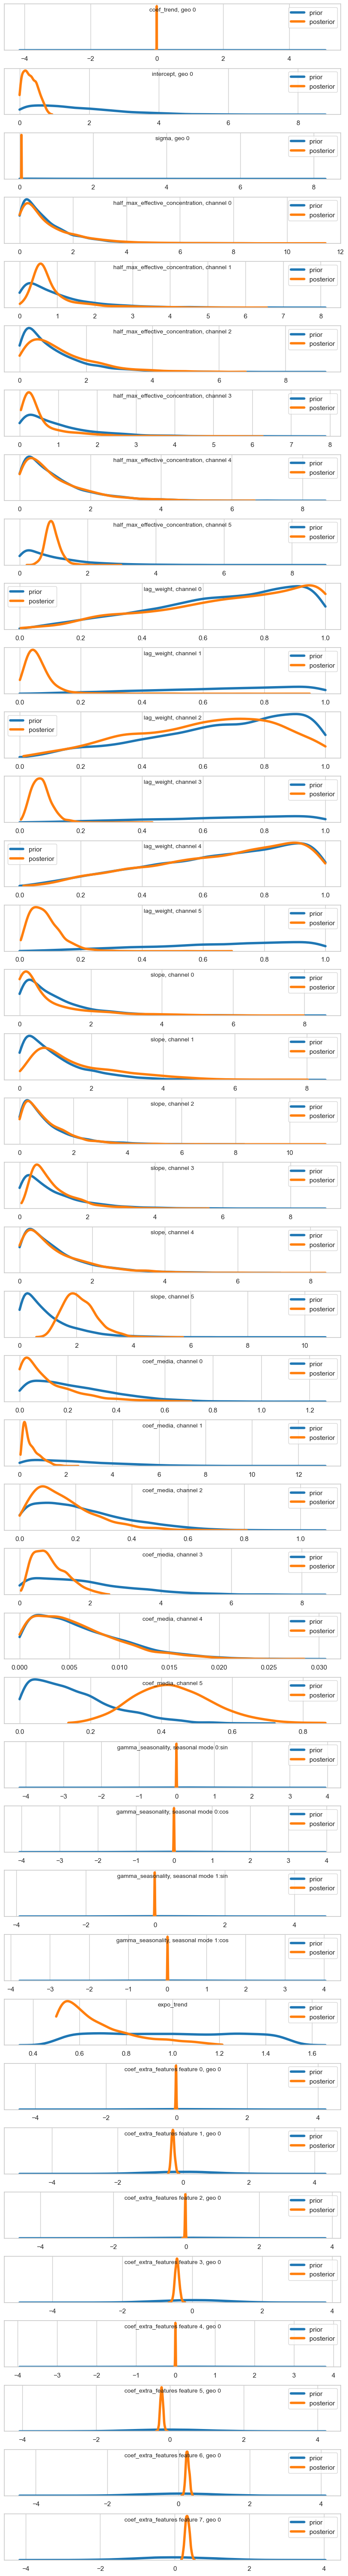

In [1918]:
# Generating a figure that visualizes the prior and posterior distributions of the media mix model
fig = plot.plot_prior_and_posterior(media_mix_model=mmm)

# Saving the figure to a file
fig.savefig('prior_posterior_plot.png')

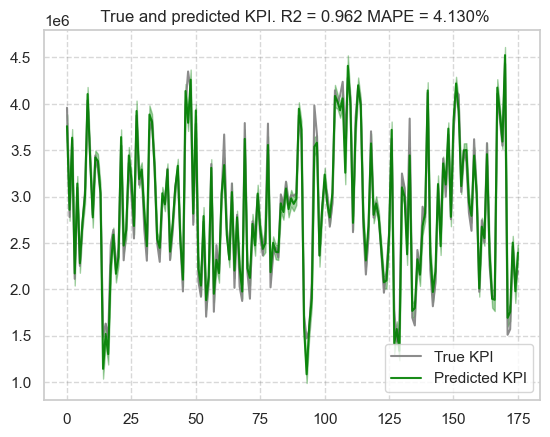

In [1919]:
# Plotting the model's fit on training data
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [1920]:
# Predicting on the test data
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test), 
                              extra_features=extra_features_scaler.transform(extra_features_test_data)
                              ,seed=105)
new_predictions.shape

(2000, 23)

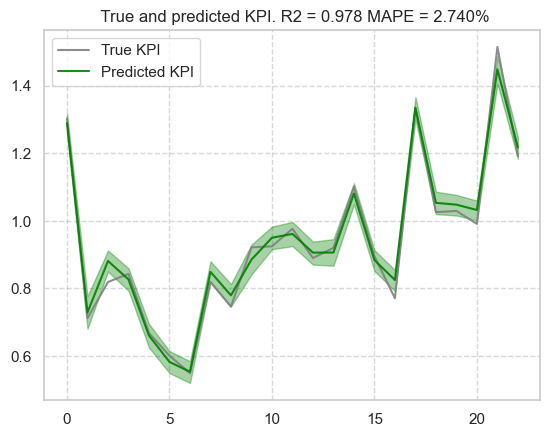

In [1921]:
# Plotting the model's fit on test data
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                  out_of_sample_target=target_scaler.transform(target_data_test))
                                 

# 6. Media Insights

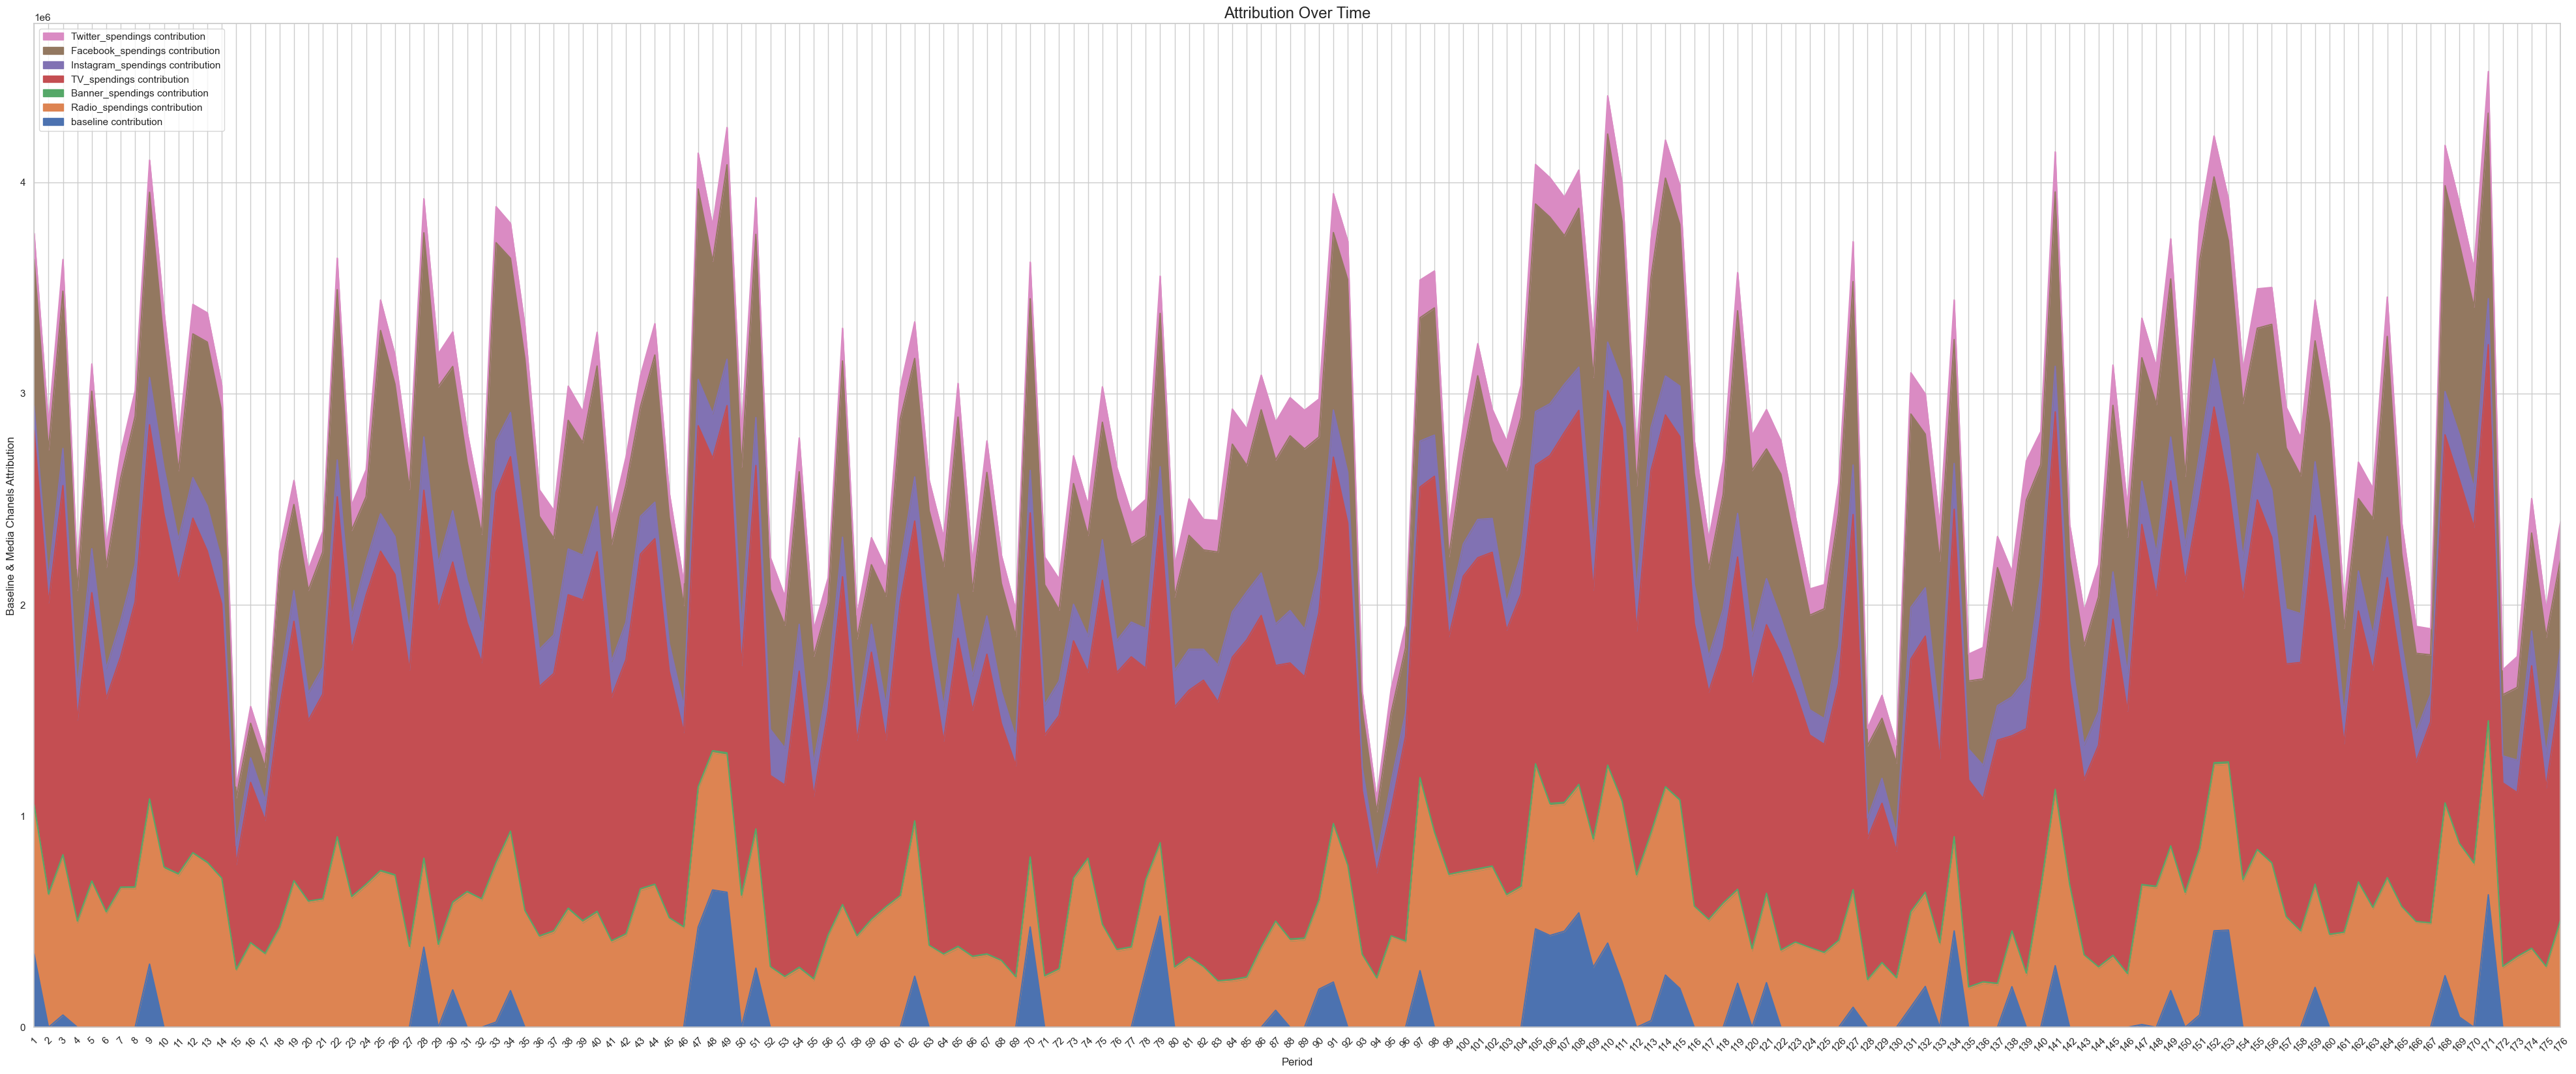

In [1922]:
# Visualising the estimated media & baseline contribution over time
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=costs_scaler)

plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(50,20))
     

/Users/shivataherzadeh/anaconda3/lib/python3.10/site-packages/lightweight_mmm/plot.py:859: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metric, ci=None, ax=ax)


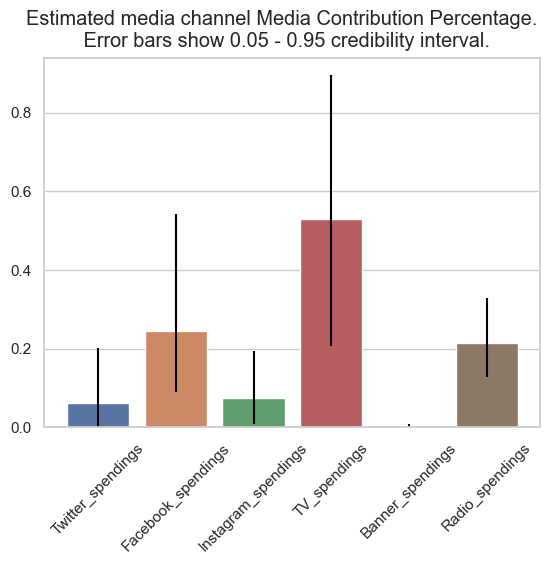

In [1923]:
# Visualising the estimated media contributions with their respective credibility intervals
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", 
                             channel_names=['Twitter_spendings', 'Facebook_spendings', 'Instagram_spendings',
       'TV_spendings', 'Banner_spendings', 'Radio_spendings'])


/Users/shivataherzadeh/anaconda3/lib/python3.10/site-packages/lightweight_mmm/plot.py:859: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metric, ci=None, ax=ax)


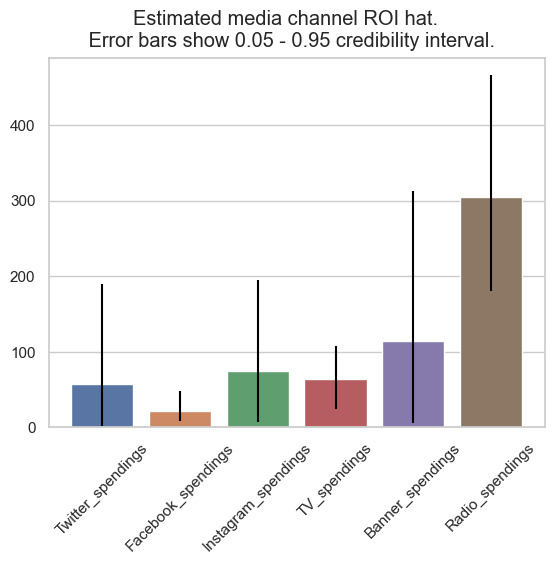

In [1924]:
# Visualising the ROI of each media activity and their credibility interval
plot.plot_bars_media_metrics(metric=roi_hat,
                             metric_name="ROI hat",
                             channel_names=['Twitter_spendings', 'Facebook_spendings', 'Instagram_spendings',
       'TV_spendings', 'Banner_spendings', 'Radio_spendings'])


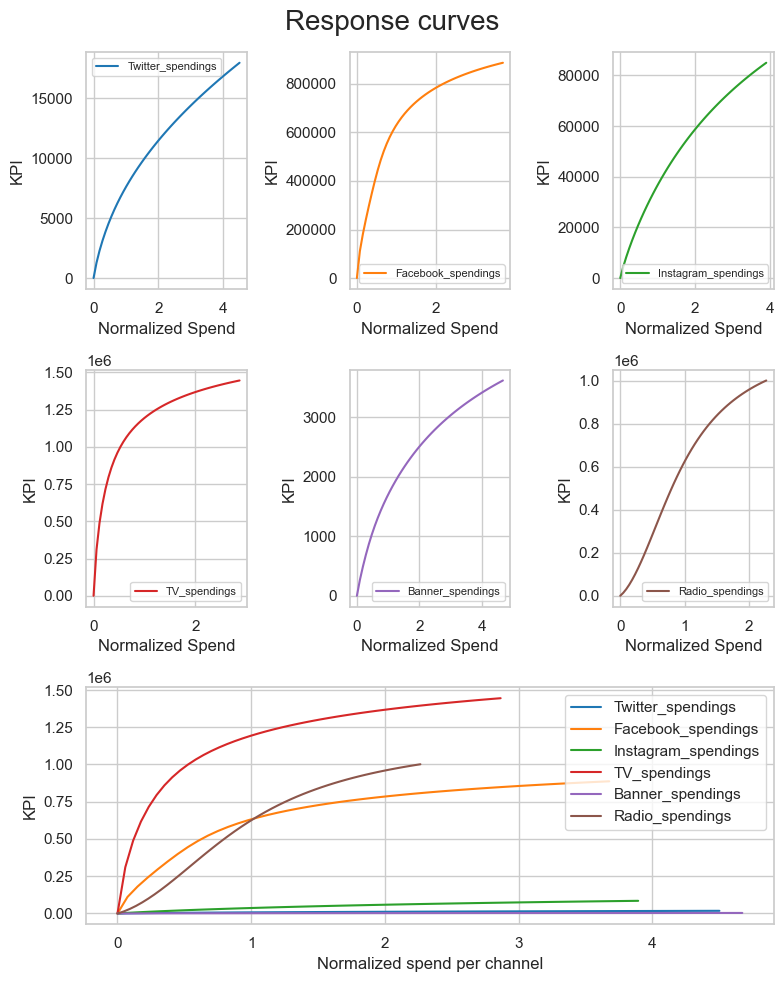

In [1925]:
# Plotting the curve response of all media channels,
# to see how each media channel behaves individually as we invest more in it
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=105)

# 7. Marketing Budget Allocation Optimisation

In [1926]:
#  Average price expected for the media units of each channel,because our data is already in monetary units, our prices should be an array of 1s
prices = jnp.ones(mmm.n_media_channels)

# Total budget for 2020
budget = 3000000

# Total number of weeks for 1 year
n_time_periods = 52 

In [1927]:
# Running optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    seed=105)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -225618140.0109631
            Iterations: 32
            Function evaluations: 403
            Gradient evaluations: 31


In [1928]:
solution

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -225618140.0109631
       x: [ 1.132e+05  1.326e+06  1.562e+05  1.288e+06  4.452e+03
            1.120e+05]
     nit: 32
     jac: [-6.755e+00 -1.062e+01 -2.045e+01 -1.062e+01 -2.527e+01
           -2.613e+02]
    nfev: 403
    njev: 31

In [1929]:
# Obtaining the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([ 113211.62  , 1325687.6   ,  156219.62  , 1288438.1   ,
          4452.0713,  111990.914 ], dtype=float32)

In [1930]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([ 144800.27  , 1507056.9   ,  133205.66  , 1115648.5   ,
          3796.2014,   95492.64  ], dtype=float32)

In [1931]:
# Both these values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(3000000, Array(3000000., dtype=float32))

In [1932]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(3000000, Array(3000000., dtype=float32))

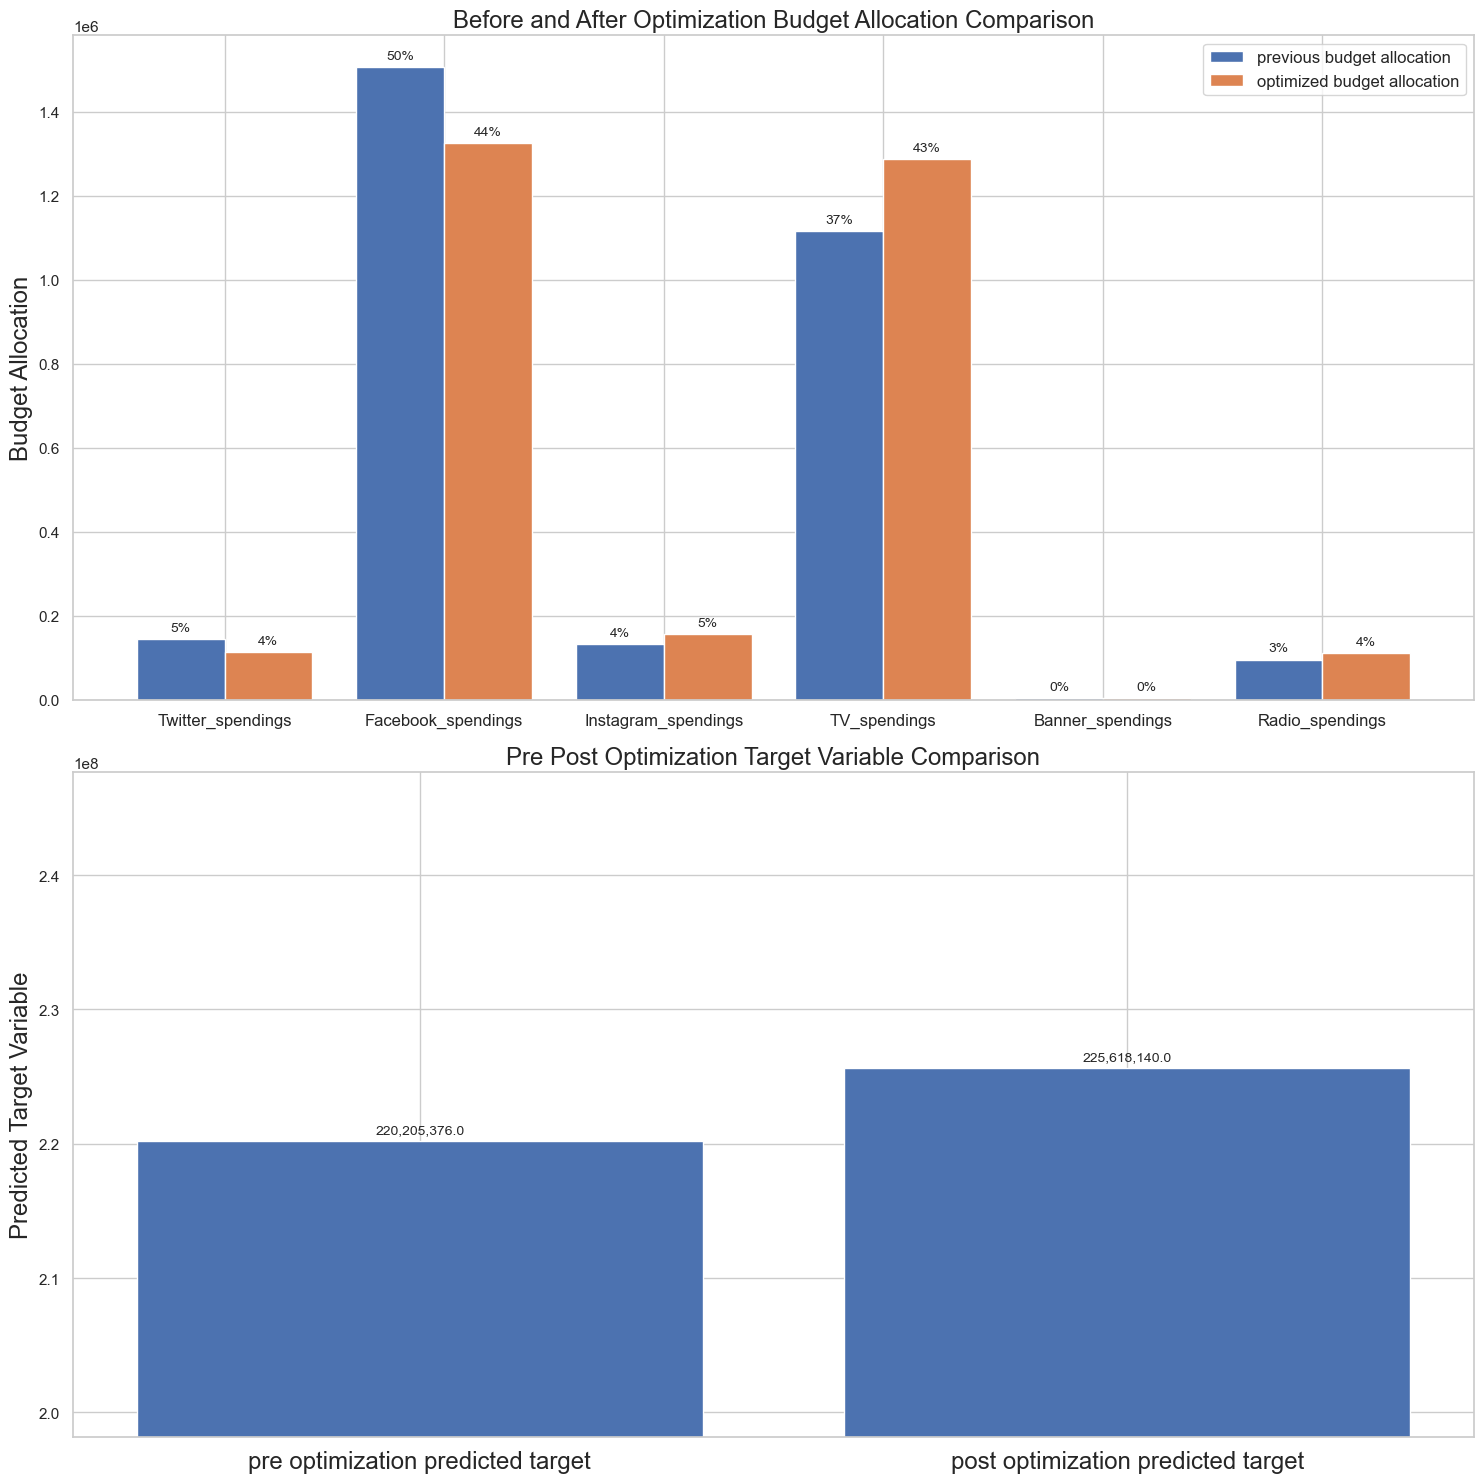

In [1933]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(15,15))